In [14]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io as scio 
import scipy.io as sio
import math
import scipy
from tensorflow.python.framework import ops
from scipy.sparse import csr_matrix 
tf.compat.v1.disable_eager_execution()


In [15]:
def random_mini_batches_GCN(X, Y, L, mini_batch_size, seed):
    
    m = X.shape[0]
    mini_batches = []
    np.random.seed(seed)
    
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :]
    shuffled_Y = Y[permutation, :].reshape((m, Y.shape[1]))
    shuffled_L1 = L[permutation, :].reshape((L.shape[0], L.shape[1]), order = "F")
    shuffled_L = shuffled_L1[:, permutation].reshape((L.shape[0], L.shape[1]), order = "F")

    num_complete_minibatches = math.floor(m / mini_batch_size)
    
    for k in range(0, num_complete_minibatches):       
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :]
        mini_batch_L = shuffled_L[k * mini_batch_size : k * mini_batch_size + mini_batch_size, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y, mini_batch_L)
        mini_batches.append(mini_batch)
    mini_batch = (X, Y, L) 
    mini_batches.append(mini_batch)
    
    return mini_batches


In [16]:
def split_data(Labeled_points, Labels, test_size=0.3, random_state=42):
     

    # Set the random seed, if provided
    if random_state is not None:
        np.random.seed(random_state)

    # Get the number of data points
    num_points = Labeled_points.shape[0]

    # Calculate the number of points to use for testing
    num_test = int(num_points * test_size)

    # Shuffle the indices of the data points
    indices = np.random.permutation(num_points)

    # Split the indices into training and testing sets
    test_indices = indices[:num_test]
    train_indices = indices[num_test:]

    # Use the indices to get the training and testing data points and labels
    X_train = Labeled_points[train_indices]
    X_test = Labeled_points[test_indices]
    y_train = Labels[train_indices]
    y_test = Labels[test_indices]

    return X_train, X_test, y_train, y_test

In [17]:


def cosine_similarity(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)
 
def adjacency_matrix(ALL_X, k=10):     
    N = ALL_X.shape[0]
    A = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            A[i, j] = cosine_similarity(ALL_X[i], ALL_X[j])
    # Convert the graph to a sparse matrix and return it
    ALL_L = csr_matrix(A)
    return ALL_L

In [18]:
def create_placeholders(n_x, n_y):

    isTraining = tf.compat.v1.placeholder_with_default(True, shape=())
    x_in = tf.compat.v1.placeholder(tf.float32,  [None, n_x], name = "x_in")
    y_in = tf.compat.v1.placeholder(tf.float32, [None, n_y], name = "y_in")
    lap_train = tf.compat.v1.placeholder(tf.float32, [None, None], name = "lap_train")
    
    return x_in, y_in, lap_train, isTraining

In [19]:

def initialize_parameters():
   
    tf.compat.v1.set_random_seed(1)

    x_w1 = tf.compat.v1.get_variable("x_w1", [224,128], initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform", seed = 1))
    x_b1 = tf.compat.v1.get_variable("x_b1", [128], initializer = tf.compat.v1.zeros_initializer())

    x_w2 = tf.compat.v1.get_variable("x_w2", [128,12], initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform", seed = 1))
    x_b2 = tf.compat.v1.get_variable("x_b2", [12], initializer = tf.compat.v1.zeros_initializer())    

    
    parameters = {"x_w1": x_w1,
                  "x_b1": x_b1,
                  "x_w2": x_w2,
                  "x_b2": x_b2}
                  
    return parameters


In [20]:

def GCN_layer(x_in, L_, weights):

    x_mid = tf.matmul(x_in, weights)
    x_out = tf.matmul(L_, x_mid)
    
    return x_out

In [21]:
def mynetwork(x, parameters, Lap, isTraining, momentums = 0.9):

    with tf.compat.v1.name_scope("x_layer_1"):

         x_z1_bn = tf.compat.v1.layers.batch_normalization(x, momentum = momentums, training = isTraining)             
         x_z1 = GCN_layer(x_z1_bn, Lap, parameters['x_w1']) + parameters['x_b1']
         x_z1_bn = tf.compat.v1.layers.batch_normalization(x_z1, momentum = momentums, training = isTraining)
         x_a1 = tf.nn.relu(x_z1_bn)      
         
    with tf.compat.v1.name_scope("x_layer_3"):
        
         x_z2_bn = tf.compat.v1.layers.batch_normalization(x_a1, momentum = momentums, training = isTraining)        
         x_z2 = GCN_layer(x_z2_bn, Lap, parameters['x_w2']) + parameters['x_b2']         

    l2_loss =  tf.nn.l2_loss(parameters['x_w1']) + tf.nn.l2_loss(parameters['x_w2'])
                
    return x_z2, l2_loss

In [22]:
def mynetwork_optimaization(y_est, y_re, l2_loss, reg, learning_rate, global_step):
    
    y_re = tf.squeeze(y_re, name = 'y_re')
    
    with tf.compat.v1.name_scope("cost"):
         cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_est, labels = tf.stop_gradient( y_re))) +  reg * l2_loss
         
    with tf.compat.v1.name_scope("optimization"):
         update_ops = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
         optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost,  global_step=global_step)
         optimizer = tf.group([optimizer, update_ops])
         
    return cost, optimizer


In [23]:

def network_accuracy(x_out, y_in):
    
    correct_prediction = tf.equal(tf.argmax(x_out, 1), tf.argmax(y_in, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
         
    return accuracy

In [24]:
def train_mynetwork(x_train, x_test, y_train, y_test, L_train, L_test, learning_rate_base = 0.001, beta_reg = 0.001, num_epochs = 200, minibatch_size = 32, print_cost = True):
    
    ops.reset_default_graph()    
    tf.compat.v1.set_random_seed(1)                          
    seed = 1                                                         
    (m, n_x) = x_train.shape
    (m, n_y) = y_train.shape
    
    costs = []                                        
    costs_dev = []
    train_acc = []
    val_acc = []
    
    x_in, y_in, lap_train, isTraining = create_placeholders(n_x, n_y) 

    parameters = initialize_parameters()
    
    with tf.compat.v1.name_scope("network"):
         x_out, l2_loss = mynetwork(x_in, parameters, lap_train, isTraining)

    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.compat.v1.train.exponential_decay(learning_rate_base, global_step, 50 * m/minibatch_size, 0.5, staircase = True)
    
    with tf.compat.v1.name_scope("optimization"):
         cost, optimizer = mynetwork_optimaization(x_out, y_in, l2_loss, beta_reg, learning_rate, global_step)

    with tf.compat.v1.name_scope("metrics"):
         accuracy = network_accuracy(x_out, y_in)

    init = tf.compat.v1.global_variables_initializer()

    with tf.compat.v1.Session() as sess:
        
        sess.run(init)
      
        # Do the training loop
        for epoch in range(num_epochs + 1):
            epoch_cost = 0.
            epoch_acc = 0.
            
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            
            minibatches = random_mini_batches_GCN(x_train, y_train, L_train, minibatch_size, seed)
            
            for minibatch in minibatches:

                # Select a minibatch
                (batch_x, batch_y, batch_l) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _, minibatch_cost, minibatch_acc = sess.run([optimizer, cost, accuracy], feed_dict={x_in: batch_x, y_in: batch_y, lap_train: batch_l, isTraining: True})           
                epoch_cost += minibatch_cost 
                epoch_acc += minibatch_acc

            epoch_cost_train = epoch_cost / (num_minibatches+ 1) 
            epoch_acc_train = epoch_acc / (num_minibatches+ 1) 

           
            if print_cost == True and epoch % 50 == 0:
                features, epoch_cost_test, epoch_acc_test = sess.run([x_out, cost, accuracy], feed_dict={x_in: x_test, y_in: y_test, lap_train: L_test, isTraining: False})
                print ("epoch %i: Train_loss: %f, Val_loss: %f, Train_acc: %f, Val_acc: %f" % (epoch, epoch_cost_train, epoch_cost_test, epoch_acc_train, epoch_acc_test))
            
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost_train)
                train_acc.append(epoch_acc_train)
                costs_dev.append(epoch_cost_test)
                val_acc.append(epoch_acc_test)

        # plot the cost      
        plt.plot(np.squeeze(costs))
        plt.plot(np.squeeze(costs_dev))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        # plot the accuracy 
        plt.plot(np.squeeze(train_acc))
        plt.plot(np.squeeze(val_acc))
        plt.ylabel('accuracy')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
      
        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")
       
       
        return parameters, val_acc, features


epoch 0: Train_loss: 2.013696, Val_loss: 2.320472, Train_acc: 0.382360, Val_acc: 0.311111
epoch 50: Train_loss: 0.793564, Val_loss: 0.931745, Train_acc: 0.757982, Val_acc: 0.707937
epoch 100: Train_loss: 0.706614, Val_loss: 0.921367, Train_acc: 0.785383, Val_acc: 0.704762
epoch 150: Train_loss: 0.653263, Val_loss: 0.923607, Train_acc: 0.801234, Val_acc: 0.711111
epoch 200: Train_loss: 0.649217, Val_loss: 0.951212, Train_acc: 0.801234, Val_acc: 0.695238


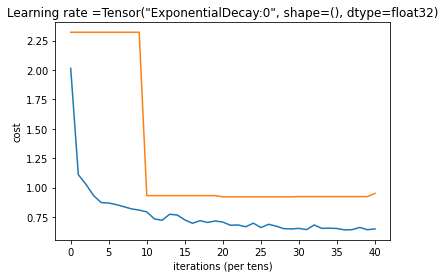

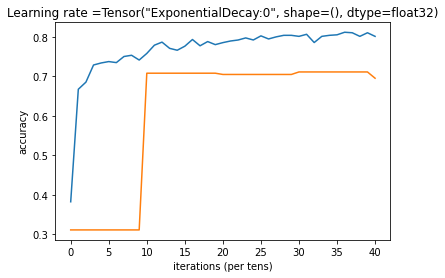

Parameters have been trained!


In [25]:

Labeled_points = scipy.io.loadmat('Labeled_Cuprite_Data/data_points.mat')['data_points']
maxVal = np.amax(Labeled_points)
minVal = np.amin(Labeled_points)
Labeled_points_shifted = Labeled_points + abs(minVal)
Labeled_points_norm = Labeled_points_shifted / (abs(minVal) + abs(maxVal))
Labeled_points_norm = Labeled_points_norm + 1e-6

Labels = scipy.io.loadmat('Labeled_Cuprite_Data/labels.mat')['labels']
Labels = Labels.T
num_classes = 12
Labels_onehot = tf.keras.utils.to_categorical(Labels, num_classes)
X_train, X_test, Y_train, Y_test = split_data(Labeled_points, Labels_onehot, test_size=0.3) 
Train_L = adjacency_matrix(X_train) 
Train_L = Train_L.astype(int)
Train_L = Train_L.todense() 

Test_L = adjacency_matrix(X_test) 
Test_L = Test_L.astype(int)
Test_L = Test_L.todense() 
 
parameters, val_acc, features = train_mynetwork(X_train, X_test, Y_train, Y_test, Train_L, Test_L)
sio.savemat('features.mat', {'features': features})